In [1]:
!pip install --upgrade pip
!pip install transformers==4.16 --quiet
!pip install vncorenlp==1.0.3 --quiet
!sudo apt-get install git-lfs
!pip install sentencepiece --quiet
!pip install tokenizer --quiet
!pip install underthesea --quiet
!pip install numpy --quiet
!pip install pandas --quiet
!pip install seaborn --quiet
!pip install torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 36 not upgraded.
Need to get 3544 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 git-lfs amd64 3.0.2-1ubuntu0.3 [3544 kB]
Fetched 3544 kB in 1s (2407 kB/s)  
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package git-lfs.
(Reading database ... 16754 files and directories currently installed.)
Preparing to unpack .../git-lfs_3.0.2-1ubuntu0.3_amd64.deb ...
Unpacking git-lfs (3.0.2-1ubuntu0.3) ...
Setting up git-

In [2]:
!pip install pyvi --quiet
!pip install gensim --quiet
!pip install openpyxl --quiet

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyvi import ViTokenizer
from gensim.utils import simple_preprocess


import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(20082004)

In [6]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df
train_df = get_data('/workspace/train_nor_811.xlsx')
valid_df = get_data('/workspace/valid_nor_811.xlsx')
test_df = get_data('/workspace/test_nor_811.xlsx')

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        text = ViTokenizer.tokenize(text)
        label = self.labelencoder(row['Emotion'])

        return text, label

In [8]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

In [9]:
train_dataset = SentimentDataset(train_df, tokenizer, max_len=120)
valid_dataset = SentimentDataset(valid_df, tokenizer, max_len=120)
test_dataset = SentimentDataset(test_df, tokenizer, max_len=120)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [10]:
# hyperparameters
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 5e-5

In [12]:
class TeacherModel(nn.Module):
    def __init__(self, n_classes, drop_out=0.1):
        super(TeacherModel, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base-v2")
        self.l1 = torch.nn.Linear(768, 256)
        self.l2 = torch.nn.Linear(256, n_classes)
        self.d1 = torch.nn.Dropout(drop_out)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = output[1]
        output = self.l1(output)
        output = self.d1(output)
        output = self.l2(output)
        return output

teacher_model = TeacherModel(n_classes=7)
teacher_model.to(device)
teacher_model.load_state_dict(torch.load('/workspace/teacher_model.pth'), strict = False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [13]:
import torch.nn.functional as F
def loss_fn_kd(outputs, labels, teacher_outputs, alpha, T):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss
weights = torch.FloatTensor([0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

In [14]:
def train_kd(model, teacher_model, optimizer, scheduler, train_loader, alpha, T):
    # set model to training mode
    model.train()
    teacher_model.eval()
    
    total_loss = total = 0
    total_correct = 0
    predictions = []
    labels = []
    for batch in train_loader:

        label = batch['targets'].type(torch.LongTensor)
        label = label.to(device)
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        student_output = model(input_ids, attention_masks)
        student_output = student_output.logits

        with torch.no_grad():
            teacher_output = teacher_model(input_ids, attention_masks)
        
        # Calculate how wrong the model is
        loss = loss_fn_kd(student_output, label, teacher_output, alpha, T)
        preds = torch.argmax(student_output, dim=1)

        total_correct += torch.sum(preds == label.data)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(label)
        
    return total_correct / total, total_loss / total

def validate_kd(model, valid_loader):
    model.eval()
    total_loss = total = 0
    total_correct = 0
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in valid_loader:
            label = batch['targets'].type(torch.LongTensor)
            label = label.to(device)
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks)
            output = output.logits

            preds = torch.argmax(output, 1)
            predictions.append(preds.flatten())
            labels.append(label.data)
            
            total_correct += torch.sum(preds == label.data)

            # Calculate how wrong the model is
            loss = criterion(output, label)

            # Record metrics
            total_loss += loss.item()
            total += len(label)

    predictions = torch.cat(predictions).detach().cpu()
    labels = torch.cat(labels).detach().cpu()
    return total_correct / total, total_loss / total, predictions

In [15]:
def predict_test_kd(model, test_loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in test_loader:
            label = batch['targets'].type(torch.LongTensor)
            label = label.to(device)
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks)

            _, preds = torch.max(output.logits, 1)
            predictions.append(preds.flatten())
            labels.append(label.data)

    predictions = torch.cat(predictions).detach().cpu()
    return predictions

In [16]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig

config = DistilBertConfig(
    num_labels=7,
    vocab_size=64001,
    max_position_embeddings=258
)
student_model = DistilBertForSequenceClassification(config)
student_model.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(0.2),
            nn.Linear(256, 7),)
student_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [17]:
from torch import optim
from transformers import AutoModel, AutoTokenizer, get_scheduler

In [18]:
weights = torch.FloatTensor([0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

param_optimizer = list(student_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=1e-8)
    
num_training_steps = EPOCHS * len(train_loader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [19]:
alpha = 0.8
T = 10

In [20]:
import time

best_valid_loss = 1
train_losses, valid_losses = [], []

training_start_time = time.time()

for epoch in range(EPOCHS):

    train_acc, train_loss = train_kd(student_model, teacher_model, optimizer, lr_scheduler, train_loader, alpha, T)
    valid_acc, valid_loss, val_pred = validate_kd(student_model, valid_loader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(student_model.state_dict(), 'best_student_model.pth') 

    print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
    print('-' * 10)
    print('Training Loss: {:.2e} Acc: {:.8f}'.format(train_loss, train_acc))
    print('Validate Loss: {:.2e} Acc: {:.8f}'.format(valid_loss, valid_acc))
    # print('ROC AUC Score: {: .8f}'.format(roc_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 0/9
----------
Training Loss: 3.36e-02 Acc: 0.32101658
Validate Loss: 9.73e-02 Acc: 0.38483965
Epoch 1/9
----------
Training Loss: 2.58e-02 Acc: 0.49459264
Validate Loss: 9.08e-02 Acc: 0.46209913
Epoch 2/9
----------
Training Loss: 1.95e-02 Acc: 0.61481613
Validate Loss: 9.10e-02 Acc: 0.48542276
Epoch 3/9
----------
Training Loss: 1.51e-02 Acc: 0.70944482
Validate Loss: 9.20e-02 Acc: 0.49271140
Epoch 4/9
----------
Training Loss: 1.15e-02 Acc: 0.79884642
Validate Loss: 9.74e-02 Acc: 0.51457727
Epoch 5/9
----------
Training Loss: 9.29e-03 Acc: 0.84174478
Validate Loss: 1.02e-01 Acc: 0.48833820
Epoch 6/9
----------
Training Loss: 7.23e-03 Acc: 0.88914925
Validate Loss: 1.05e-01 Acc: 0.49271140
Epoch 7/9
----------
Training Loss: 6.03e-03 Acc: 0.91852915
Validate Loss: 1.05e-01 Acc: 0.50583094
Epoch 8/9
----------
Training Loss: 5.26e-03 Acc: 0.93799567
Validate Loss: 1.07e-01 Acc: 0.50145775
Epoch 9/9
----------
Training Loss: 4.79e-03 Acc: 0.94881034
Validate Loss: 1.08e-01 Acc: 0

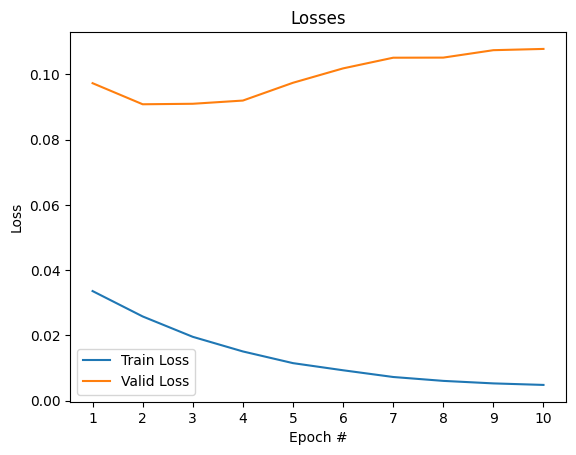

In [21]:
epoch_ticks = range(1, EPOCHS + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [22]:
predict_test_kd(student_model, test_loader)

tensor([3, 1, 1, 0, 4, 2, 2, 2, 5, 4, 2, 6, 4, 1, 0, 0, 6, 1, 4, 0, 0, 1, 6, 1,
        6, 0, 1, 0, 6, 6, 3, 1, 1, 1, 0, 2, 2, 1, 0, 4, 4, 4, 0, 6, 6, 0, 2, 6,
        2, 3, 5, 1, 0, 0, 3, 1, 1, 1, 1, 6, 6, 5, 0, 0, 1, 2, 6, 4, 0, 6, 2, 6,
        1, 6, 0, 1, 0, 6, 2, 2, 1, 4, 2, 6, 0, 3, 2, 1, 1, 2, 0, 5, 0, 2, 2, 1,
        0, 0, 5, 1, 4, 1, 1, 3, 5, 0, 3, 0, 1, 1, 0, 2, 1, 6, 2, 5, 6, 1, 1, 1,
        6, 1, 1, 0, 6, 0, 1, 6, 2, 6, 1, 1, 3, 2, 1, 3, 1, 6, 0, 0, 6, 0, 3, 1,
        0, 6, 6, 2, 2, 6, 0, 5, 2, 1, 3, 0, 6, 6, 6, 0, 1, 6, 1, 0, 5, 2, 1, 6,
        1, 0, 5, 1, 2, 6, 4, 0, 5, 2, 0, 1, 0, 3, 1, 0, 0, 0, 6, 1, 2, 4, 1, 5,
        1, 4, 6, 4, 5, 2, 6, 6, 6, 1, 1, 1, 5, 1, 0, 4, 6, 6, 5, 1, 1, 4, 3, 4,
        0, 6, 0, 1, 6, 1, 1, 3, 0, 2, 3, 6, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1,
        3, 6, 0, 0, 0, 6, 5, 2, 2, 5, 1, 0, 2, 1, 2, 0, 2, 1, 1, 0, 4, 4, 6, 1,
        1, 6, 0, 1, 1, 6, 2, 0, 0, 5, 0, 6, 1, 2, 6, 1, 2, 2, 0, 4, 6, 0, 6, 2,
        1, 0, 6, 6, 0, 0, 0, 2, 2, 0, 1,

In [25]:
student_model.eval()
total_loss = total = 0
total_correct = 0
predictions = []
labels = []
with torch.no_grad():
    for batch in test_loader:
        label = batch['targets'].type(torch.LongTensor)
        label = label.to(device)
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)

        # Forwards pass
        output = student_model(input_ids, attention_masks)
        output = output.logits

        preds = torch.argmax(output, 1)
        predictions.append(preds.flatten())
        labels.append(label.data)
        
        total_correct += torch.sum(preds == label.data)
        total += len(label)

predictions = torch.cat(predictions).detach().cpu()
labels = torch.cat(labels).detach().cpu()
print(total_correct / total)

tensor(0.5267, device='cuda:0')
